In [1]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
import IPython
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

2023-09-20 23:16:33.668817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import opendatasets as od

# token 362de83c625279a01f8399c58a63abe8
od.download("https://www.kaggle.com/vinayshanbhag/bird-song-data-set")

Skipping, found downloaded files in "./bird-song-data-set" (use force=True to force download)


In [3]:
df = pd.read_csv('bird-song-data-set/bird_songs_metadata.csv')
df.sample(10)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
3482,381570,Melospiza,melodia,NaN,Song Sparrow,Jeremy Minns,United States,"Carman Valley, Sierra County, California",39.6980,-120.4530,1500,song,//www.xeno-canto.org/381570,//creativecommons.org/licenses/by-nc-sa/4.0/,08:48,2000-06-14,Further natural song by bird recorded in XC381...,381570-0.wav
1523,321905,Mimus,polyglottos,polyglottos,Northern Mockingbird,Richard E. Webster,United States,"San Bernardino National Wildlife Refuge, Cochi...",31.3400,-109.2730,1100,song,//www.xeno-canto.org/321905,//creativecommons.org/licenses/by-nc-sa/4.0/,07:37,2015-04-30,"returned, singing on top of a brush pile then ...",321905-6.wav
3753,205806,Melospiza,melodia,NaN,Song Sparrow,Eric DeFonso,United States,"Confluence Park, Delta, Delta County, Colorado",38.7526,-108.0825,1500,song,//www.xeno-canto.org/205806,//creativecommons.org/licenses/by-nc-sa/4.0/,05:45,2014-05-29,Bird singing from pondside shrubs. One song ty...,205806-16.wav
355,325137,Thryomanes,bewickii,NaN,Bewick's Wren,Sue Riffe,United States,"Cone Mtn BBS, Las Animas County, Colorado",37.6290,-104.3157,1700,"call, song",//www.xeno-canto.org/325137,//creativecommons.org/licenses/by-nc-sa/4.0/,10:36,2016-06-11,NaN,325137-5.wav
1065,503419,Mimus,polyglottos,NaN,Northern Mockingbird,Brian Hendrix,United States,"Chapel Hill, Marshall County, Tennessee",NaN,NaN,400,song,//www.xeno-canto.org/503419,//creativecommons.org/licenses/by-nc-sa/4.0/,16:30,2019-10-20,Recorded using Bird Genie on iPhone 11 Pro Max...,503419-3.wav
194,351093,Thryomanes,bewickii,charienturus,Bewick's Wren,Richard E. Webster,United States,"Lake Hodges, San Diego, California",33.0523,-117.0804,100,"call, song",//www.xeno-canto.org/351093,//creativecommons.org/licenses/by-nc-sa/4.0/,?,1995-04-09,NaN,351093-3.wav
3432,408014,Melospiza,melodia,heermanni Group,Song Sparrow,Frank Lambert,United States,"Andrew Molera Park (near Big Sur), Monterey C...",36.2886,-121.8446,30,song,//www.xeno-canto.org/408014,//creativecommons.org/licenses/by-nc-nd/4.0/,06:10,2015-05-18,NaN,408014-5.wav
3265,480068,Melospiza,melodia,NaN,Song Sparrow,Thomas G. Graves,United States,"Montana de Oro State Park, Los Osos, San Luis ...",35.2557,-120.8872,30,"call, song",//www.xeno-canto.org/480068,//creativecommons.org/licenses/by-nc-sa/4.0/,19:45,2019-06-07,Bird singing in tree about 50 feet off the tra...,480068-6.wav
2642,322565,Turdus,migratorius,propinquus,American Robin,Richard E. Webster,United States,"Onion Saddle, Chiricahua Mountains, Cochise Co...",31.9330,-109.2640,2200,song,//www.xeno-canto.org/322565,//creativecommons.org/licenses/by-nc-sa/4.0/,06:42,2015-05-20,singing from several exposed perches high in b...,322565-1.wav
2718,310256,Turdus,migratorius,migratorius,American Robin,Daniel Parker,United States,"Oscawana, Croton, New York",NaN,NaN,?,song,//www.xeno-canto.org/310256,//creativecommons.org/licenses/by-nc-sa/4.0/,17:30,2016-03-11,NaN,310256-8.wav


In [4]:
directory = 'bird-song-data-set/wavfiles/'

In [5]:
df = df[['name', 'filename']]
df['filename'] = df['filename'].apply(lambda filename: directory + filename)

In [6]:
df.sample(5)

,name,filename
1840,Northern Mockingbird,bird-song-data-set/wavfiles/130970-3.wav
4527,Northern Cardinal,bird-song-data-set/wavfiles/470299-11.wav
749,Bewick's Wren,bird-song-data-set/wavfiles/172751-2.wav
1978,Northern Mockingbird,bird-song-data-set/wavfiles/21732-1.wav
1394,Northern Mockingbird,bird-song-data-set/wavfiles/321943-13.wav


In [7]:
def get_spectrogram(filepath=None, y=None, sr=None):
    if filepath:
        y, sr = librosa.load(filepath)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    return log_ms

In [8]:
def get_(filepath=None, y=None, sr=None):
    if filepath:
        y, sr = librosa.load(filepath)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    return log_ms

In [9]:
df['spectrogram'] = df['filename'].apply(get_spectrogram)
df.sample(5)

,name,filename,spectrogram
631,Bewick's Wren,bird-song-data-set/wavfiles/205433-4.wav,"[[-5.3130016, -4.7907887, -7.8861446, -6.38702..."
846,Bewick's Wren,bird-song-data-set/wavfiles/15270-1.wav,"[[-57.970158, -63.969296, -80.0, -80.0, -80.0,..."
3446,Song Sparrow,bird-song-data-set/wavfiles/393994-1.wav,"[[-52.335945, -58.38344, -80.0, -80.0, -80.0, ..."
1007,Northern Mockingbird,bird-song-data-set/wavfiles/541426-11.wav,"[[-57.909954, -63.809372, -80.0, -80.0, -80.0,..."
1102,Northern Mockingbird,bird-song-data-set/wavfiles/489315-7.wav,"[[-51.45352, -45.91307, -42.755043, -39.757675..."


In [10]:
X = df[['spectrogram', 'filename']]
y = df['name']
x_max = np.max(np.abs(np.array(df['spectrogram'].tolist())))

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)


In [12]:
def get_important_x_y(x, y):
    x_new = x / x_max
    x_new = np.array(x_new.to_list())
    y_new = pd.get_dummies(np.array(y))
    return x_new, y_new

In [13]:
x_test_files = list(zip(list(x_test['filename']), list(y_test)))

In [14]:
x_train, y_train = get_important_x_y(x_train['spectrogram'], y_train)
x_test, y_test = get_important_x_y(x_test['spectrogram'], y_test)
x_val, y_val = get_important_x_y(x_val['spectrogram'], y_val)
print(x_train.shape, y_train.shape)

(3252, 128, 130) (3252, 5)


In [15]:
input_size = x_train[0].shape
input_size

(128, 130)

In [16]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_size))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 32)           12512     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 28, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 128)          0

In [17]:
model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))
model.save('model')

Epoch 1/30
51/51 [==============================] - 3s 36ms/step - loss: 1.4214 - accuracy: 0.3364 - val_loss: 1.1783 - val_accuracy: 0.4387
Epoch 2/30
51/51 [==============================] - 2s 31ms/step - loss: 1.1067 - accuracy: 0.4960 - val_loss: 1.0064 - val_accuracy: 0.5714
Epoch 3/30
51/51 [==============================] - 1s 29ms/step - loss: 0.9712 - accuracy: 0.5806 - val_loss: 0.9071 - val_accuracy: 0.6065
Epoch 4/30
51/51 [==============================] - 1s 29ms/step - loss: 0.9179 - accuracy: 0.5956 - val_loss: 0.8561 - val_accuracy: 0.6378
Epoch 5/30
51/51 [==============================] - 1s 25ms/step - loss: 0.8678 - accuracy: 0.6258 - val_loss: 0.8377 - val_accuracy: 0.6590
Epoch 6/30
51/51 [==============================] - 1s 25ms/step - loss: 0.8183 - accuracy: 0.6442 - val_loss: 0.8639 - val_accuracy: 0.6129
Epoch 7/30
51/51 [==============================] - 1s 25ms/step - loss: 0.8130 - accuracy: 0.6479 - val_loss: 0.8067 - val_accuracy: 0.6516
Epoch 8/30
51

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [18]:
model = tf.keras.models.load_model('model')

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)

34/34 [==============================] - 0s 3ms/step - loss: 0.5708 - accuracy: 0.8166


In [20]:
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
embeddings = embedding_model.predict(x_test)

34/34 [==============================] - 0s 2ms/step


In [21]:
print(embeddings)

[[0.         3.6612713  9.530011   ... 0.         0.         0.        ]
 [0.         3.8749478  5.556074   ... 0.         0.         0.23624511]
 [0.         0.         0.         ... 4.532443   0.         1.2611088 ]
 ...
 [2.9568384  0.         0.         ... 2.4173582  0.050895   0.        ]
 [0.         1.7042687  0.         ... 4.042702   1.0218362  2.859544  ]
 [0.         0.6090459  1.2356406  ... 0.69759405 1.3760892  0.43401515]]


In [22]:
X = umap.UMAP().fit_transform(embeddings)

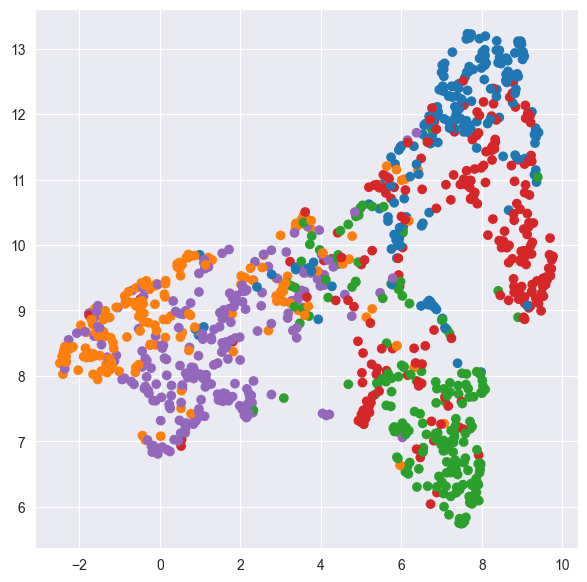

In [23]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.scatter(X[:, 0], X[:, 1], color=[sns.color_palette()[number] for number in y_test.apply(np.argmax, axis=1)])
plt.show()

In [52]:
vectors = list(embeddings)
vector_names = list(x_test_files)

In [53]:
def get_nearest_vectors(vectors) -> (int, int):
    from scipy.spatial.distance import euclidean
    
    min_distance = float('inf')
    min_pair = None
    
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            distance = euclidean(vectors[i], vectors[j])
            if distance < min_distance:
                min_distance = distance
                min_pair = (i, j)
    print(f"The most similar pair of vectors is: {min_pair}")
    return min_pair

In [65]:
i1, i2 = get_nearest_vectors(vectors)
print(vector_names[i1])
print(vector_names[i2])

The most similar pair of vectors is: (463, 589)
('bird-song-data-set/wavfiles/564311-16.wav', 'Northern Cardinal')
('bird-song-data-set/wavfiles/564311-6.wav', 'Northern Cardinal')


In [66]:
IPython.display.Audio(vector_names[i1][0])

In [67]:
IPython.display.Audio(vector_names[i2][0])

In [68]:
del vectors[i1]
del vector_names[i1]